# Advanced programming and data analysis

## HSE University, 2024-25 Academic Year

# Practice 3. Random Forest


## 1. Bias-Variance decomposition

ВLet’s recall that the loss function in regression or classification tasks can be broken down into three components: **bias**, **variance**, and **noise**. These components help us describe the complexity of an algorithm, offering an alternative to simply comparing training and test errors.

Although this decomposition can be applied to any loss function, it is most straightforward (and traditional) for the **mean squared error** (**MSE**) in a regression setting — which is what we’ll look at below.

Let’s say we have a dataset $(X, y)$. We train our algorithm on this data and make predictions on the same dataset. We'll denote the predictions as $\hat{y}$. Then…


$$
\mathrm{bias} := \mathbb{E}(\hat{y}) - y
$$

$$
\mathrm{variance} := \mathbb{E}[\mathbb{E}(\hat{y}) - \hat{y}]^2
$$

$$
\mathrm{noise} := \mathbb{E}[y - \mathbb{E}(y)]^2
$$

The expected mean squared error on the training set can be decomposed as follows:


$$
\mathrm{E}[y - \hat{y}]^2 = \mathrm{bias}^2 + \mathrm{variance} + \mathrm{noise}.
$$

**Challenge for the brave:** Show that this decomposition is valid. You can check your solution [here](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture08-ensembles.pdf).


**Technical note:** All expectations in the decomposition above are taken over the training data points. This means the decomposition is valid for the mean squared error on the training set, which is sometimes called the *MSE for estimator*.

However, we are often more interested in the error on unseen data — also known as the *MSE for predictor*. In this case, the expected error should be calculated over unseen data points.

To address this, we usually assume that the training and test data come from the same distribution, and take the expectation over all possible variations of the training set. The core idea of the decomposition remains the same, but its notation becomes more complex. You can explore this further [here](https://towardsdatascience.com/mse-and-bias-variance-decomposition-77449dd2ff55).


ЗNote that in practice, since we estimate expectations and often have access to a test set, there is no issue with calculating **estimates** of both the MSE for estimator and the MSE for predictor.

Now let’s look at how to interpret the components:

* **Bias** is the difference between the average prediction of the algorithm and the prediction of the ideal model. Bias reflects the error caused by the model being too simple. High bias usually indicates **underfitting**.

* **Variance** is the variability of the algorithm’s predictions around its average prediction. It shows how much predictions change when the training data changes slightly. Variance reflects the error due to the model being overly complex. High variance usually indicates **overfitting**.

* **Noise** is the error of the ideal model — the natural, irreducible randomness in the data.

Let’s take a visual look at this using an example with polynomial regression.

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.auto import trange

warnings.filterwarnings("ignore")

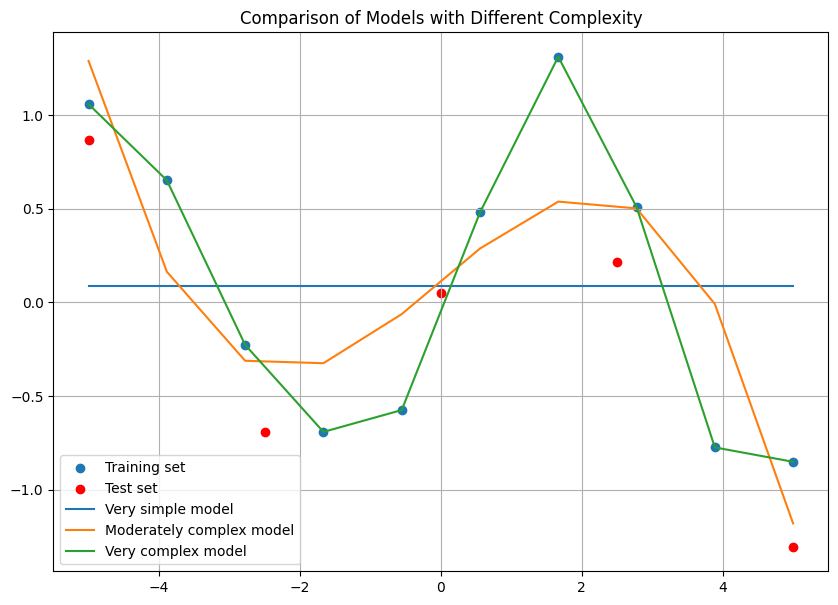

In [ ]:
# The dataset
np.random.seed(42)
N = 10
X = np.linspace(-5, 5, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.2, size=N).reshape(-1, 1)

X_test = np.linspace(-5, 5, N // 2).reshape(-1, 1)
y_test = np.sin(X_test) + np.random.normal(0, 0.2, size=N // 2).reshape(-1, 1)

# A very simple model (regression on a constant)
too_simple_model_predictions = np.mean(y) * np.ones_like(y)

# A moderately complex model
X_ok = np.hstack([X, X**2, X**3])
ok_model = LinearRegression()
ok_model.fit(X_ok, y)
ok_model_predictions = ok_model.predict(X_ok)

# A very complex model
X_compl = np.hstack(
    [X, X**2, X**3, X**4, X**5, X**6, X**7, X**8, X**9, X**10]
)
compl_model = LinearRegression()
compl_model.fit(X_compl, y)
compl_model_predictions = compl_model.predict(X_compl)

plt.figure(figsize=(10, 7))

plt.title("Comparison of Models with Different Complexity")
plt.scatter(X, y, label="Training set")
plt.scatter(X_test, y_test, c="r", label="Test set")
plt.plot(X, too_simple_model_predictions, label="Very simple model")
plt.plot(X, ok_model_predictions, label="Moderately complex model")
plt.plot(X, compl_model_predictions, label="Very complex model")
plt.grid()
plt.legend();

**Task:** Using the definitions above, explain the observed phenomena:

* A very simple model has high bias but low (zero) variance. The model is clearly underfitting.
* A moderately complex model has low bias and low variance.
* A very complex model has low bias but high variance. The model is clearly overfitting.

**Task:** Comment on the bias and variance for the following models:

* Linear regression trained on a large dataset without outliers and with no multicollinearity, where the features are strongly correlated with the target variable.
* A decision tree that is grown until each leaf contains only one sample.
* Logistic regression that assigns all points to the same class.


### Bias-Variance Tradeoff

As described above, training a model involves a tradeoff between bias and variance:
an underfitted model has low variance but high bias,
while an overfitted model has low bias but high variance.

This tradeoff can be visualized in the following diagram
([source](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update)).
Here, **Total Error** represents the test error (generalization error).

![](https://www.bradyneal.com/img/bias-variance/fortmann-roe-bias-variance.png)

The conclusion is clear: we should aim to build models with optimal complexity.

But does this tradeoff always apply when training any model?
Recent research shows that the behavior of test error in some (modern) models doesn't always follow the classic U-shaped curve.

For example, it has been observed that test error continues to decrease as neural networks grow larger (e.g., by increasing the number of layers):

<img src="https://www.bradyneal.com/img/bias-variance/neyshabur.jpg" alt="drawing" width="400"/>

In such models, the error curve takes on a more complex form:

<img src="https://www.bradyneal.com/img/bias-variance/double_descent.jpg" alt="drawing" width="800"/>






## 2. From Decision Trees to Random Forests

### 2.1. Decision Tree

The motivation behind building a Random Forest algorithm can be conveniently explained in terms of **bias** and **variance**.
Let’s start by looking at how a decision tree is built.


In [ ]:
california = fetch_california_housing()
california_X = pd.DataFrame(data=california.data, columns=california.feature_names)
california_Y = california.target
print(f"X shape: {california_X.shape}, Y shape: {california_Y.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    california_X, california_Y, test_size=0.3, random_state=123, shuffle=True
)

X shape: (20640, 8), Y shape: (20640,)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# TODO: Train a decision tree without any restrictions on the training set

# TODO: Calculate MSE on both the training and test sets

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

# TODO: Output the average bias and average variance of the model on the test set

As we discussed in the previous lecture, such a tree will likely be highly overfitted — meaning it has **high variance** and **low bias**. Let’s try to fix that.

In the lecture, we talked about one way to reduce overfitting: by building **model ensembles**. In this seminar, we’ll focus on constructing ensembles using a technique called **bagging**.


### 2.2. Bagging

Let’s recall how the algorithm works:

1. Train many decision trees independently on bootstrap samples of the original dataset.
   A bootstrap sample is created by randomly selecting $N$ observations (where $N$ is the size of the original dataset) **with replacement**.

2. Average the predictions of all the models (for example, by taking the mean).

It can be shown that a model built using bagging will have **the same bias** as the individual trees,
but significantly **lower variance** (under certain conditions).


In [ ]:
from sklearn.ensemble import BaggingRegressor

base_tree = DecisionTreeRegressor(random_state=123)

# TODO: Train a bagging ensemble with 20 trees, each built without restrictions

# TODO: Calculate MSE on both the training and test sets

# TODO: Output the average bias and average variance of the model on the test set

As we can see, compared to a single decision tree, the **bias** has remained almost the same, but the **variance** has decreased significantly! The mean squared error on the training set is no longer zero, and the error on the test set has gone down — which means we successfully reduced the overfitting of the single decision tree.

Can we reduce overfitting even further? Yes, we can!


### 2.3. Random Forest

While building each tree in bagging, we can further reduce overfitting by selecting a **random subset of features** at each split, instead of using all available features. This helps reduce the correlation between trees, which in turn lowers the overall **variance** of the final model. This approach is known as a **Random Forest**.

Compared to a single decision tree, a Random Forest has a few additional parameters:

* `max_features` – the number of features to consider when looking for the best split.

* `n_estimators` – the number of trees in the forest.

Of course, all the parameters used in a single decision tree still apply to each tree within the random forest.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# TODO: Train a random forest with 20 trees, each built without restrictions

# TODO: Calculate MSE on both the training and test sets

# TODO: Output the average bias and average variance of the model on the test set

As we can see, compared to bagging, the **bias** has once again remained almost unchanged, while the **variance** has decreased slightly. Of course, with well-tuned hyperparameters, we could reduce the variance even further.

The training error has increased, but the test error has decreased — which means we’ve achieved our goal of reducing overfitting from individual decision trees!

## 3. Characteristics of Random Forest

### 3.1. Number of Trees and “Random Forest Does Not Overfit”

In his [blog](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks), Leo Breiman — the creator of Random Forest — wrote the following:

> Random forest does not overfit. You can run as many trees as you want.

**Note:** As mentioned in the lecture, Random Forest does **not overfit as the number of trees increases**, thanks to the combination of bagging and random feature selection — but this doesn’t mean it can’t overfit **in general**.

Let’s take a look at how Random Forest behaves as we increase the number of trees.

  0%|          | 0/50 [00:00<?, ?it/s]

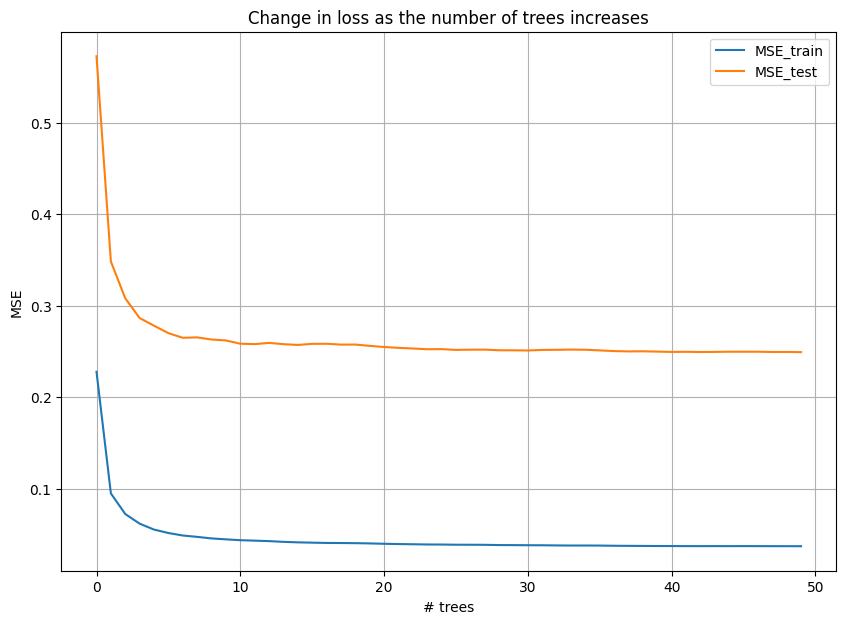

In [ ]:
n_trees = 100
train_loss = []
test_loss = []

for i in trange(1, n_trees, 2):
    rf = RandomForestRegressor(n_estimators=i, random_state=123, n_jobs=4)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 7))
plt.title("Change in loss as the number of trees increases")
plt.grid()
plt.plot(train_loss, label="MSE_train")
plt.plot(test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("# trees")
plt.legend();

As expected, once the number of trees reaches a certain point, both training and test errors stabilize — meaning that adding more trees does **not** lead to overfitting.

However, in practice, changing other parameters **can** lead to overfitting on real-world data:
[example 1](https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit),
[example 2](https://mljar.com/blog/random-forest-overfitting/).

For instance, a Random Forest with limited-depth trees may sometimes predict **more accurately** than one with fully grown trees.

In our case, the Random Forest may actually suffer from **too much regularization**.
Let’s take a look at how the model behaves when we vary the **maximum depth** of the trees (and feel free to experiment with other parameters as well).


  0%|          | 0/25 [00:00<?, ?it/s]

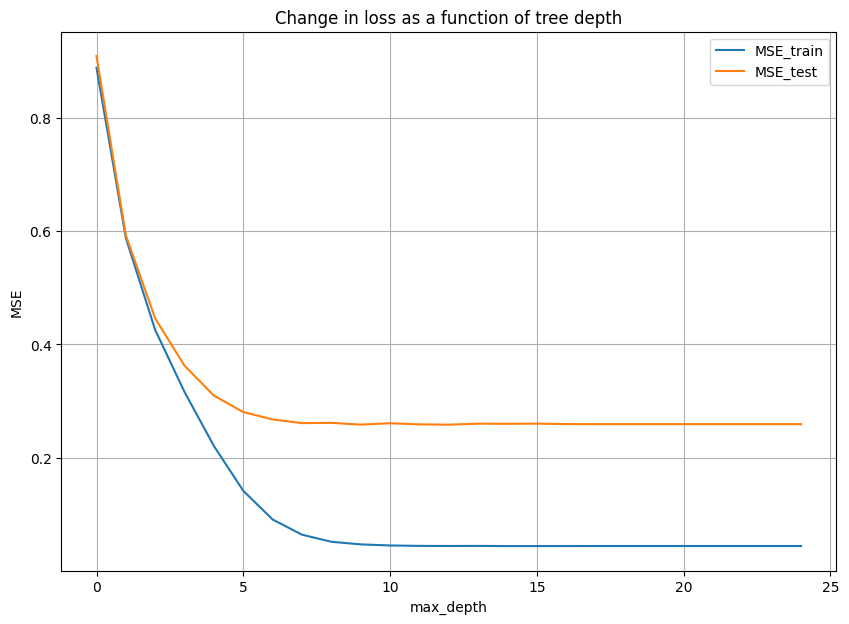

In [ ]:
max_depth = 50
train_loss = []
test_loss = []

for i in trange(1, max_depth, 2):
    rf = RandomForestRegressor(n_estimators=20, max_depth=i, random_state=123, n_jobs=4)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 7))
plt.title("Change in loss as a function of tree depth")
plt.grid()
plt.plot(train_loss, label="MSE_train")
plt.plot(test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("max_depth")
plt.legend();

No overfitting is observed here.
In general, as always, the hyperparameters of a Random Forest should be tuned using cross-validation.

### 3.2. Out-of-Bag Error

As we discussed earlier, in a Random Forest, each tree is trained on a **bootstrap sample**, which is created by randomly sampling from the original training set **with replacement**. Naturally, some observations will appear multiple times in a bootstrap sample, while others won’t appear at all.

For each tree, we can use the samples **not included** in its training set to evaluate its performance — essentially using them for validation.

The average error on these left-out samples across all trees is called the **out-of-bag (OOB) error**.


In [ ]:
# oob_score_ = R² on unseen (out-of-bag) samples
rf = RandomForestRegressor(n_estimators=100, random_state=123, oob_score=True, n_jobs=4)
rf.fit(X_train, y_train)
rf.oob_score_

0.800305147049665

### 3.3. Feature Importance

Just like decision trees, Random Forests can be used to evaluate **feature importance**.
One common way to measure importance is by looking at how much a feature **reduces impurity** (or randomness) across all the splits where it is used.


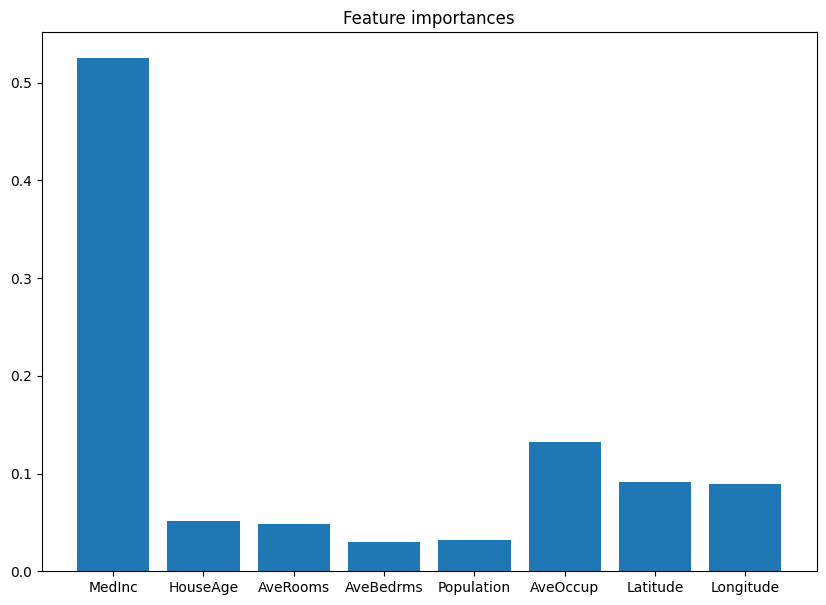

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(california["feature_names"], rf.feature_importances_);

Be careful with highly correlated features.
Let’s see what happens to feature importance if we add a **linearly dependent** feature to the dataset.


In [ ]:
RM_mc = np.array((X_train.iloc[:, 5] * 2 + 3)).reshape(-1, 1)
X_train_new = np.hstack((X_train, RM_mc))

In [ ]:
rf.fit(X_train_new, y_train)

RandomForestRegressor(n_jobs=4, oob_score=True, random_state=123)

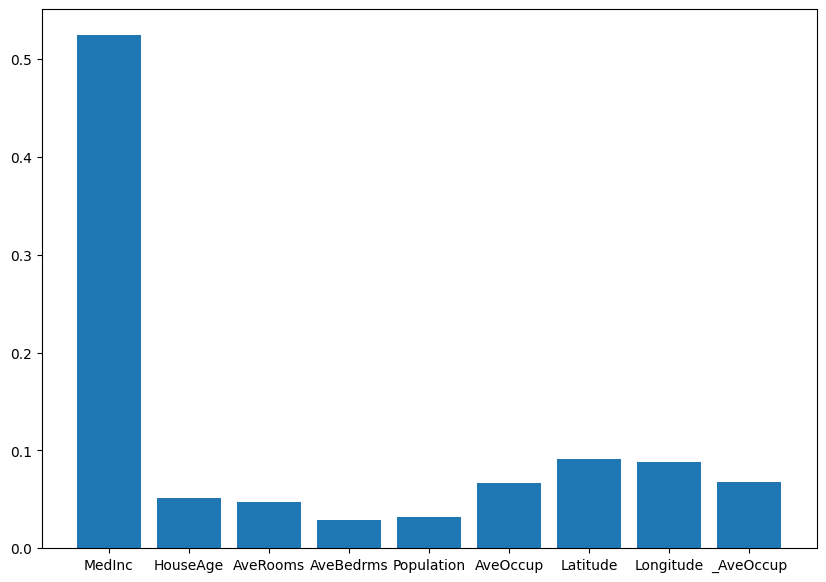

In [ ]:
plt.figure(figsize=(10, 7))
names = list(california["feature_names"])
names.append("_AveOccup")
plt.bar(names, rf.feature_importances_);

The importances were redistributed between the linearly dependent features `AveOccup` and `_AveOccup`.
Keep in mind feature correlations when using this method for feature selection.

Also, take note of the warning in the `sklearn` documentation:
this method should **not** be used for features with many unique values, such as categorical features with only a few categories.

## 4. Testing Random Forest on Different Datasets

Below are templates for comparing Random Forest with other models on various types of data.
Try running more experiments using different models and evaluation metrics.
You can also tune Random Forest hyperparameters to reach a specific performance threshold.

**Note: Random Forest can take a long time to train.**

### 4.1. Binary Classification: [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)


In [ ]:
# Data downloading
!wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

In [ ]:
data = pd.read_csv("kaggle_response.csv")
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# TODO: Train a logistic regression and a random forest with default parameters
# Compare their AUC ROC scores on the test set

### 4.2. Image Classification: [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
import torchvision

fmnist = torchvision.datasets.FashionMNIST("./", download=True)
X, y = fmnist.data.numpy().reshape(-1, 28 * 28), fmnist.targets.numpy()

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


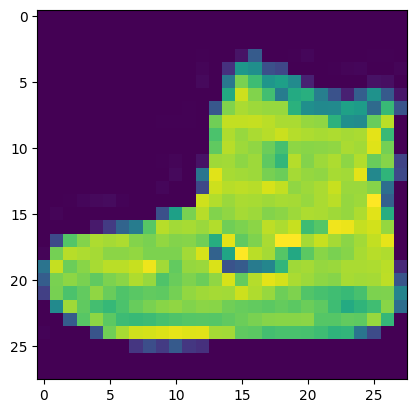

In [ ]:
plt.imshow(X[0, :].reshape(28, 28));

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# TODO: Train a Random Forest and k-Nearest Neighbors (kNN) with default parameters
# Compare their accuracy scores on the test set